# Introdução

Spam de email ou lixo eletrônico é um tipo de spam que se utiliza o email para o envio de mensagens indesejadas, ou seja, que não foram solicitadas pelo destinatário. Além disso, eles servem como vetor para ataques tipo phishing ou mesmo golpes cada vez mais elaborados por estelionatários. Por dia, estima-se que mais de 100 bilhões de spams são enviados por e-mail.

**O que desejo é que o e-mail precisa ser classificado como spam ou ham com base no conteúdo do e-mail.**

# Sobre os Dados

Link para o database: https://spamassassin.apache.org/old/publiccorpus/

O Spam Assassin Dataset é uma seleção de mensagens de e-mail, adequado para uso em testes de sistemas de filtragem de spam. Este conjunto específico foi obtido do Apache Public Datasets , limpo e organizado em um arquivo csv de uma maneira que possa ser conveniente de usar.

O conjunto de dados é a combinação de ```spam```, ```spam_2```, ```easy_ham``` e ```easy_ham_2```.

Os e-mails de spam:

* O ```spam``` conteúdo continha 500 mensagens de spam, todas recebidas de fontes não spam-trap.
* O ```spam_2``` continha 1397 mensagens de spam. Estes são mais recentes.

Os e-mails não spam: 

* O ```easy_ham``` continha 2500 mensagens não spam. Normalmente, é muito fácil diferenciá-los de spam, pois frequentemente não contêm assinaturas "spam" (como HTML, etc.).
* O ```easy_ham_2``` continha 1400 mensagens não spam. Como spam_2 uma adição mais recente ao conjunto.

# Análise Exploratória de Dados

## Importação das bibliotecas básicas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Base de Dados

In [2]:
base_emails = pd.read_csv('data/spam_assassin.csv')

In [3]:
base_emails

,text,target
0,From ilug-admin@linux.ie Mon Jul 29 11:28:02 2...,0
1,From gort44@excite.com Mon Jun 24 17:54:21 200...,1
2,From fork-admin@xent.com Mon Jul 29 11:39:57 2...,1
3,From dcm123@btamail.net.cn Mon Jun 24 17:49:23...,1
4,From ilug-admin@linux.ie Mon Aug 19 11:02:47 2...,0
...,...,...
5791,From ilug-admin@linux.ie Mon Jul 22 18:12:45 2...,0
5792,From fork-admin@xent.com Mon Oct 7 20:37:02 20...,0
5793,Received: from hq.pro-ns.net (localhost [127.0...,1
5794,From razor-users-admin@lists.sourceforge.net T...,0


O conjunto de dados contém 2 colunas "Text" que representa o corpo do email e "target" que é sua classificação.

In [4]:
base_emails.describe()

,target
count,5796.000000
mean,0.327122
std,0.469203
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Pela média, percebe-se que a base de dados é desbalanceada, ou seja, há muitos mais emails classifcados como ham do que como spam

[Text(0, 0, '3900'), Text(0, 0, '1896')]

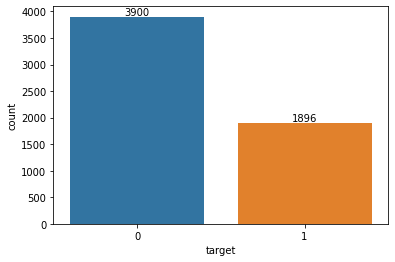

In [5]:
ax = sns.countplot(x = base_emails['target'])
ax.bar_label(container= ax.containers[0], labels = base_emails['target'].value_counts(ascending=False).values)

### Verificando Valores Faltantes

In [6]:
base_emails.isnull().sum()

text      0
target    0
dtype: int64

Perfeito, não há dados faltantes na base de dados

### Divisão entre Previsores e Classe

In [15]:
X_emails = base_emails.iloc[:, 0].values #text
X_emails[0]

"From ilug-admin@linux.ie Mon Jul 29 11:28:02 2002 Return-Path: <ilug-admin@linux.ie> Delivered-To: yyyy@localhost.netnoteinc.com Received: from localhost (localhost [127.0.0.1]) by phobos.labs.netnoteinc.com (Postfix) with ESMTP id A13D94414F for <jm@localhost>; Mon, 29 Jul 2002 06:25:11 -0400 (EDT) Received: from phobos [127.0.0.1] by localhost with IMAP (fetchmail-5.9.0) for jm@localhost (single-drop); Mon, 29 Jul 2002 11:25:11 +0100 (IST) Received: from lugh.tuatha.org (root@lugh.tuatha.org [194.125.145.45]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g6RHn7i17130 for <jm-ilug@jmason.org>; Sat, 27 Jul 2002 18:49:07 +0100 Received: from lugh (root@localhost [127.0.0.1]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id SAA25016; Sat, 27 Jul 2002 18:45:03 +0100 X-Authentication-Warning: lugh.tuatha.org: Host root@localhost [127.0.0.1] claimed to be lugh Received: from mail1.mail.iol.ie (mail1.mail.iol.ie [194.125.2.192]) by lugh.tuatha.org (8.9.3/8.9.3) with ESMTP id SAA24977 f

In [16]:
y_emails = base_emails.iloc[:, 1].values #target
y_emails[0]

0

### Divisão das bases em treinamento e teste

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_emails_treinamento, X_emails_teste, y_emails_treinamento, y_emails_teste = train_test_split(X_emails, y_emails, test_size = 0.25, random_state = 0)

In [32]:
print("Base Total: ", np.shape(base_emails))
print("Base de Treino: ", np.shape(X_emails_treinamento))
print("Base de Teste: ", np.shape(X_emails_teste))

Base Total:  (5796, 2)
Base de Treino:  (4347,)
Base de Teste:  (1449,)


### Limpeza nos Corpos dos Emails

A primeira coisa que devemos fazer ao tratar com o corpo dos emails é retirar as palavras irrelevantes e sem sentido.

Para isso, vamos utilizar a biblioteca ```nltk```, que fornece um conjunto de bibliotecas e programas para processamento simbólico e estatístico de linguagem natural para inglês.

Além disso, usaremos o Vetorizador TF-IDF do scikit-learn. Este é um algoritmo muito comum para transformar texto em uma representação significativa de números que é usada para ajustar o algoritmo da máquina para previsão. 

In [7]:
import pickle
#!pip install nltk
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

#### TODO: TALVEZ EU TENHA QUE FAZER ISSO

Entretanto, há mais palavras específicas nos emails consideradas ```stopwords```. Então vamos fazer nosso próprio arquivo de ```stopwords``` e juntar com o do ```nltk```.

Portanto, a ideia é tentar remover as palavras de alta frequência que ocorrem em ambas as classes-alvo e nas stopwords do inglês. Não afetaria o desempenho, pois está presente em ambas as classes.

In [39]:
tfv = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b([a-zA-Z]{4,12})\b')
tfv.fit(X_emails_treinamento)
X_emails_treinamento = tfv.transform(X_emails_treinamento)